In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

In [4]:
def read_values_LJ():
    """
    paramaters
    ----------
    density : density of the system
    dx : displacement max
    T : temperature

    Returns
    -------
    parameters : dict
        Dictionary containing the parameters of the system
    results : dict
        Dictionary containing the tries, acceptances, overlaps and final energy
    all_positions : list
        List of the positions of the particles
    """
    parameters = {}
    results = {}
    all_positions = []
    for i in range(10):
        with open('./EX11_equilibration/run{}.xyz'.format(i), 'r') as file:
            lines = file.readlines()

        #Parameters are equal for each realization
        if i == 0:
            parameters["N"] = int(lines[0].split('=')[1].strip())
            parameters["N_steps"] = int(lines[1].split('=')[1].strip())
            parameters["box_x"] = float(lines[2].split('=')[1].strip())
            parameters["box_y"] = float(lines[3].split('=')[1].strip())
            parameters["box_z"] = float(lines[4].split('=')[1].strip())
            parameters["temperature"] = float(lines[5].split('=')[1].strip())
            parameters["delta_x"] = float(lines[6].split('=')[1].strip())
            parameters["myseed"] = int(lines[7].split('=')[1].strip())
            parameters["sigma"] = float(lines[8].split('=')[1].strip())
            parameters["model"] = int(lines[9].split('=')[1].strip())
            parameters["density"] = float(lines[13].split('=')[1].strip())
        
            results["tries"] = [int(lines[10].split('=')[1].strip())]
            results["accepted"] = [int(lines[11].split('=')[1].strip())]
            results["overlap"] = [int(lines[12].split('=')[1].strip())]
            results["E"] = [float(lines[14].split('=')[1].strip())]
            results["P"] = [float(lines[15].split('=')[1].strip())]

        else:
            results["tries"].append(int(lines[10].split('=')[1].strip()))
            results["accepted"].append(int(lines[11].split('=')[1].strip()))
            results["overlap"].append(int(lines[12].split('=')[1].strip()))
            results["E"].append(float(lines[14].split('=')[1].strip()))
            results["P"] = [float(lines[14].split('=')[1].strip())]
        # Parse the positions
        positions = []
        for line in lines[17:]:
            pos = list(map(float, line.split()[1:]))
            positions.append(pos)
        all_positions.append(positions)
    return parameters, results, all_positions


## Equilibration

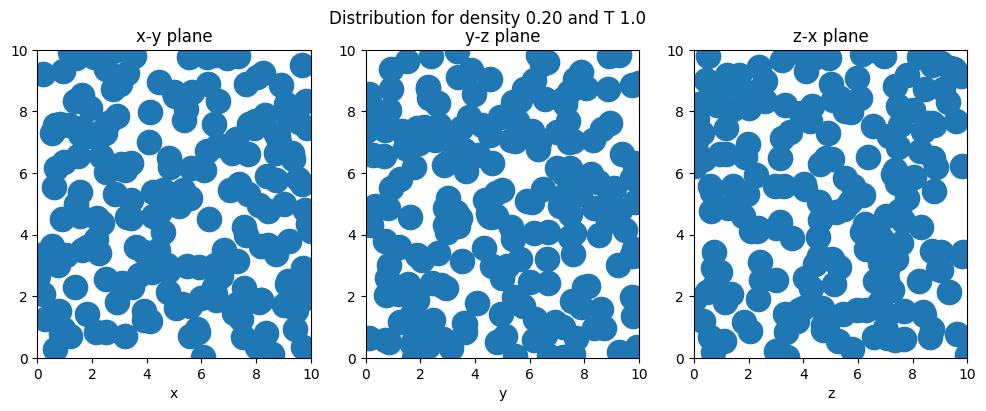

In [8]:
def plot_densities_2D():
    r_int = randint(0,9) #Plot one random realization
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    params, res, all_pos = read_values_LJ()
    T = params["temperature"]
    density = params["density"]
    for j in range(3):
        i_ax_vals_x = [pos[j] for pos in all_pos[r_int]]
        i_ax_vals_y = [pos[(j+1)%3] for pos in all_pos[r_int]]

        axes[j].set_xlim([0, params[f"box_{'xyz'[j]}"]])
        axes[j].set_ylim([0, params[f"box_{'xyz'[(j+1)%3]}"]])
        axes[j].set_title("{}-{} plane".format('xyz'[j], 'xyz'[(j+1)%3]))

        ax = axes[j]

        # Calculate the diameter in data units
        diameter_data_units = 1  # Change this to match your sigma

        # Calculate the diameter in display units
        diameter_display_units = np.diff(ax.transData.transform([(0, 0), (diameter_data_units, 0)]), axis=0)[0]

        # Convert the diameter from display units to points
        diameter_points = diameter_display_units[0] * 72 / plt.gcf().dpi

        # Calculate the area of the marker in points^2
        marker_area = np.pi * (diameter_points / 2)**2

        # Plot the data
        ax.scatter(i_ax_vals_x, i_ax_vals_y, s=marker_area)

    axes[0].set_xlabel('x')
    axes[1].set_xlabel('y')
    axes[2].set_xlabel('z')
    fig.suptitle("Distribution for density {:.2f} and T {:.1f}".format(density,T))

plot_densities_2D()


## Initial velocities

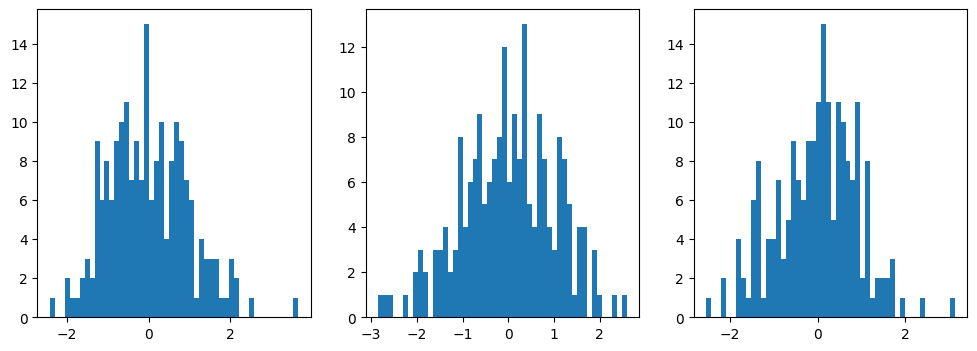

Mean vx = 0.00
Mean vy = 0.00
Mean vz = 0.00


In [25]:
velocities = np.loadtxt("./data/run1_velocities.xyz")
vx = velocities[:,0]
vy = velocities[:,1]
vz = velocities[:,2]

normal_dist = lambda x, mu, sigma: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))
xs = np.linspace(-3, 3, 100)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(vx, bins=50)
axes[1].hist(vy, bins=50)
axes[2].hist(vz, bins=50)
plt.show()

print(r"Mean vx = {:.2f}".format(np.mean(vx)))
print(r"Mean vy = {:.2f}".format(np.mean(vy)))
print(r"Mean vz = {:.2f}".format(np.mean(vz)))